# Part 1: Language Models

## Part 1.1: Data Exploration

### 1.1.1: Gathering and Cleaning Up Data

In [2]:
import nltk
import re
import string
import itertools
from collections import Counter
from nltk import word_tokenize
from urllib import request

# PTB clean up function
def ptb_preprocess(filenames,top=10000):
    for filename in filenames:
        response = request.urlopen(filename)  # open file
        raw = response.read().decode('utf-8-sig')  # decode text
        raw = raw.lower()  # normalize to lower case
        sents = nltk.sent_tokenize(raw)  # split to sentences
        tokenize_sents = [word_tokenize(s) for s in sents]  # tokenize

        # remove punctuation
        no_punct_sents = list()
        for sent in tokenize_sents:
            s = list()
            for word in sent:
                if not re.fullmatch('[' + string.punctuation + ']+', word):
                    s.append(word)
            no_punct_sents.append(s)

        # count 10,000 most common tokens
        c = Counter(itertools.chain(*no_punct_sents))
        top_tokens = c.most_common(top)
        top_tokens = dict(top_tokens)  # turn top tokens to a dictionary

        # replace numbers with 'N' and less common words with '<unk>'
        for s in no_punct_sents:
            for i in range(len(s)):
                word = s[i]
                if word.isnumeric():
                    s[i] = 'N'
                elif word not in top_tokens:
                    s[i] = '<unk>'

        # write to a txt file
        final_text = ''
        for s in no_punct_sents:
            final_text = final_text + ' '.join(s) + '\n'
        # print(final_text)
        new_file_name = filename.split('/')
        f = open(new_file_name[len(new_file_name) - 1]+'.out', "w", encoding="utf-8")
        f.write(final_text)

The above function recieves a list of urls, each is expected to contain a txt file, and performs a Penn Tree Bank (PTB) clean up. Then the cleaned-up text is saved to a new file.  

In [100]:
# example 1 - sentence segmentation
ptb_preprocess(['http://www.gutenberg.org/files/2554/2554-0.txt'])
f = open('2554-0.txt.out',encoding="utf8")
text = f.read()
print(text[:1485])

the project gutenberg ebook of crime and punishment by fyodor dostoevsky this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever
you may copy it give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title crime and punishment author fyodor dostoevsky release date march N N ebook N last updated october N N language english character set encoding utf-8 start of this project gutenberg ebook crime and punishment produced by john bickers and dagny crime and punishment by fyodor dostoevsky translated by constance garnett translator ’ s preface a few words about dostoevsky himself may help the english reader to understand his work
dostoevsky was the son of a doctor
his parents were very hard-working and deeply religious people but so poor that they lived with their five children in only two rooms
the father and mother spent their evenings in reading aloud to their children g

The begininng of this text is not really a structure of sentences, but a record like structure: "title: ...", "author:...", "release date:..." etc. The clean-up function did no recognized this structure, and considered it all as one sentence, although in the original text these parts appear in different lines. 

In [103]:
# example 2 - tokenization of numbers
ptb_preprocess(['http://www.gutenberg.org/cache/epub/6130/pg6130.txt'])
f = open('pg6130.txt.out',encoding="utf8")
text = f.read()
print(text[:1000])

the project gutenberg ebook of the iliad of homer by homer this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever
you may copy it give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at http //www.gutenberg.org/license title the iliad of homer author homer release date september N ebook N language english character set encoding iso 8859-1 ***start of the project gutenberg ebook the iliad of homer*** the iliad of homer translated by alexander pope with notes by the rev
theodore alois buckley m.a. f.s.a
and flaxman 's designs
N contents introduction
pope 's preface to the iliad of homer book i. book ii
book iii
book iv
book v. book vi
book vii
book viii
book ix
book x. book xi
book xii
book xiii
book xiv
book xv
book xvi
book xvii
book xviii
book xix
book xx
book xxi
book xxii
book xxiii
book xxiv
concluding note
illustrations homer invoking the muse
mars
minerva repressing the fury of ac

In this example, from Homer's Iliad, there is a table of contents with roman figures. Ideally, we would like our clean-up algorithm to identify them as numbers and replace them with the token N, but it fails to do so since it mistakenly identifies them as words.

In [4]:
ptb_preprocess(['https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'])
f = open('shakespeare_input.txt.out',encoding="utf8")
text = f.read()
print(text[:2000])

first citizen before we proceed any further hear me speak
all speak speak
first citizen you are all resolved rather to die than to famish
all resolved
resolved
first citizen first you know caius marcius is chief enemy to the people
all we know't we know't
first citizen let us kill him and we 'll have corn at our own price
is't a verdict
all no more talking o n't let it be done away away
second citizen one word good citizens
first citizen we are accounted poor citizens the patricians good
what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us <unk> but they think we are too dear the leanness that <unk> us the object of our misery is as an inventory to <unk> their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become <unk> for the gods know i speak this in hunger for bread not in thirst for revenge
second citizen would you proceed especially against caius marcius


This is the output of the function over Shakespeare's work. It is possible to notice that the clean-up omittes the structure of the play: speaker and his words in the same line, no ':' symbol to emphasize the identity of the speaker. We can also see that the veraity of words in the corpus is large, since in this small piece of the processed text, there are not so few '<unk>' symbols. 

### 1.1.2: Gathering Basic Statistics

Next, we take a pre-cleaned-up dataset, and provide some statistics.
<br>
The following code loads the ptb.train dataset, which is already tokenized, and prints the total number of tokens, characters, and distinct words.

In [5]:
f = open('ptb.train.txt')
raw = f.read()
raw_as_list = raw.split()

print('Total number of tokens: ' + str(len(raw_as_list)))  # print number of tokens
print('Total number of characters: ' + str(len(raw)))  # print number of characters

vocabulary = sorted(set(raw_as_list)) # create vocabulary
print('Total number of distinct words: ' + str(len(vocabulary)))

Total number of tokens: 887521
Total number of characters: 5101618
Total number of distinct words: 9999


The following function prints the total number of tokens corresponding to the top-N most frequent words in the vocabulary. We demonstrate it with N=100

In [13]:
from collections import *
def n_top_words(N):
    f = open('ptb.train.txt')
    raw = f.read()
    raw_as_list = raw.split()
    
    c = Counter(raw_as_list)
    top_tokens = c.most_common(N)
    top_n_tokens = 0
    for item in top_tokens[:N]:
        top_n_tokens = top_n_tokens + item[1]
    print('Total occurrences of top '+ str(N) + ' most frequent tokens: ' + str(top_n_tokens))
    
n_top_words(100)

Total occurrences of top 100 most frequent tokens: 464313


For examining the diffrence between ptb.train and ptb.valid, we would compute the number of types that appear in ptb.valid, and don't appear in ptb.train.

In [7]:
f = open('ptb.valid.txt')
raw_valid = f.read()
raw_valid_as_list = raw_valid.split()
valid_vocabulary = sorted(set(raw_valid_as_list)) 
train_voc_set = set(vocabulary)
valid_voc_set = set(valid_vocabulary)
only_in_valid = valid_voc_set.difference(train_voc_set)
print('Number of type in valid but not in train: ' + str(len(only_in_valid)))

Number of type in valid but not in train: 0


There are no types that appear in valid data but not in train data. This is not surprising, since normally a train set should be much larger and reacher than validation set, for better generalization in learning.

Next, we show how to compute some additional statistics

In [6]:
import statistics
print('Type-to-token ratio: ' + str(len(raw_as_list)/len(vocabulary))) # type/token ratio
char_per_token = list()
for token in raw_as_list:
    char_per_token.append(len(token))
print('Average number of characters per token: ' + str(statistics.mean(char_per_token))) # average of char per token
print('Standard deviation of number of characters per token: ' + str(statistics.stdev(char_per_token))) # std of char per token

Type-to-token ratio: 88.76097609760976
Average number of characters per token: 4.653367075257938
Standard deviation of number of characters per token: 2.6019176159122384


In [15]:
from nltk import ngrams

# print number of distinct n-grams with n=2,3,4
twograms = list(ngrams(raw_as_list, 2))
print('Total number of distinct 2-grams: ' + str(len(set(twograms))))
threegrams = list(ngrams(raw_as_list, 3))
print('Total number of distinct 3-grams: ' + str(len(set(threegrams))))
fourgrams = list(ngrams(raw_as_list, 4))
print('Total number of distinct 4-grams: ' + str(len(set(fourgrams))))

# print number of distinct character n-grams with n=2,3,4,5,6,7
chrs = [c for c in raw]
for n in range(2, 8):
    chargrams = list(ngrams(chrs, n))
    print('Total number of distinct character ' + str(n) + '-grams: ' + str(len(set(chargrams))))

Total number of distinct 2-grams: 277477
Total number of distinct 3-grams: 615618
Total number of distinct 4-grams: 771492
Total number of distinct character 2-grams: 778
Total number of distinct character 3-grams: 6304
Total number of distinct character 4-grams: 29620
Total number of distinct character 5-grams: 106312
Total number of distinct character 6-grams: 292892
Total number of distinct character 7-grams: 606835


This code above computes and prints the total number of distinct n-grams with n=2,3,4 and the total number of distinct character n-grams with n=2,3,4,5,6,7. Naturally, the total number of distinct n-grams increases with n, since the probability of observing the same sequence many times is samller when n grows. The same trend can be observed with the character n-grams. One may also notice that the number of distinct 2-grams is much greater than the number of distinct charcter 2-grams. This follows the fact that the number of distinct words is significantly larger compared to the number of distinct characters. 

Text(0, 0.5, 'frequency')

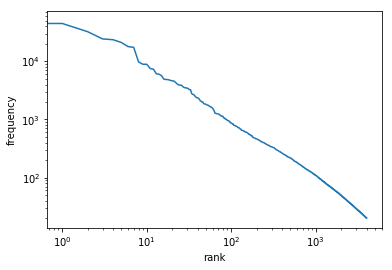

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

corpus_counts = Counter(raw_as_list)
plt.loglog([val for word, val in corpus_counts.most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency')

In the above plot, which shows each word's log-frequency againt its log-rank, it is possible to see that the curve is nearly linear.

## 1.2: n-gram Word Language Model

In [17]:
import nltk
from nltk.probability import *

# train a language model
def train_word_lm(dataset, n=2):
    pad = '* ' * n
    dataset = pad + dataset
    data_as_list = dataset.split()
    cfd = nltk.ConditionalFreqDist((' '.join(data_as_list[i: i + n]), data_as_list[i + n]) for i in range(len(data_as_list) - n))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd

# returns P(word|context)
def ngram_prob(ngramModel, word, context):
    probDist = ngramModel[context].freqdist()
    return probDist.freq(word)

The above function returns a representation of an n-gram model. The model, i.e. the parameters, is stored in a ConditionalProbDist object, which is based on a dictionary (dict object). The keys are the history, for example cpd['I like'] would give the distribution of words that can come after 'I like', in a 2-gram model.
<br>
We also provie the method ngram_prob(ngramModel, word, context), which gets an n-gram model (the output of train_word_lm), a context and a word (both strings), and returns the probability of the word to appear in the given context.
<br>
The memory needed is the number of parameters in the model. In the worst case, this number is about |V|^n, when V is the vocabulary. In our case it is 10,000^2, or 10^8. However, in the expected case, some of the sequences repeat, and this number would be smaller.

## 1.3: Language Model Evaluation

### 1.3.1: Perplexity

In [36]:
import math
def entropy(ngram_model, text, n=2):
    text = '* ' * n + text  # padding
    e = 0.0
    text_as_list = text.split()
    for i in range(len(text_as_list)-n):
        context = text_as_list[i:i + n]
        token = text_as_list[i + n]
        lp = -math.log(ngram_prob(ngram_model, token, ' '.join(context)),2)
        e += lp
    return e / float(len(text_as_list) - n)

def perplexity(ngram_model, text, n=2):
    return math.pow(2, entropy(ngram_model,text))

# print the perplexity of the 2-gram learned with ptb.train against the same dataset
f1 = open('ptb.train.txt')
train_data = f1.read()
ptb_model = train_word_lm(train_data)
f2 = open('ptb.valid.txt')
valid_data = f2.read()
print(perplexity(ptb_model, train_data))

6.442987882987743


The above code prints the perplexity of the 2-gram model that was learned with ptb.train dataset against ptb.train. The perplexity is equal to 6.443. A lower perplexity implies of a better generalization. We would like to compute the perplexity of the above model against a validation set, ptb.valid. The problem is that some of the observation's probabilities would be zero, and *log(0)* is undefined. Hence we provide the following code: 

In [37]:
# returns P(word|context) with Lidstone smoothing
def ngram_lidstone_prob(ngramModel, word, context, gamma):
    freq = ngramModel[context].freqdist()  # get frequency of the context
    if freq.B() == 0: # if the context was not observed in training, the number of bins is the size of the vocabulary (10k)
        lidstone = LidstoneProbDist(freq, gamma, 10000) 
    else:
        lidstone = LidstoneProbDist(freq, gamma)  # create Lidstone object
    return lidstone.prob(word)  # return the smooth probability of the word

def entropy_lidstone(ngram_model, text, gamma, n=2):
    text = '* ' * n + text  # padding
    e = 0.0
    text_as_list = text.split()
    for i in range(len(text_as_list)-n):
        context = text_as_list[i:i + n]
        token = text_as_list[i + n]
        lp = -math.log(ngram_lidstone_prob(ngram_model, token, ' '.join(context), gamma), 2)
        e += lp
    return e / float(len(text_as_list) - n)

def perplexity_lidstone(ngram_model, text, gamma, n=2):
    return math.pow(2, entropy_lidstone(ngram_model,text, gamma, n))

print(perplexity_lidstone(ptb_model, valid_data, 0.5))

79.92869638141883


The above functions return the Lidstone smoothing of P(word|context), and the adjusted computations of the cross-entropy and the perplexity. There is still a problem of computing a probability of an unseen context. The number of bins (possible outcomes) is 0, and the Lidstone probability results in an undefined term. In case of unseen context, we provide a number of bins as the size of the vocabulary (10k), which is equivalent to compute a Lidstone smoothing for the worst case probability of 1/|V|, when V is the vocabulary.

Text(0, 0.5, 'Lidstone perplexity')

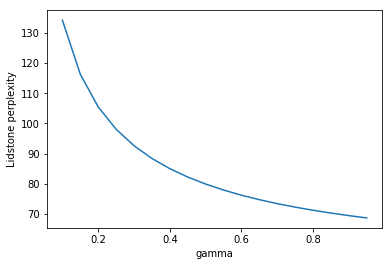

In [38]:
plt.plot([gamma for gamma in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]], [perplexity_lidstone(ptb_model,valid_data,gamma) for gamma in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]])
plt.xlabel('gamma')
plt.ylabel('Lidstone perplexity')

Perplexity with Lidstone smoothing against different values of gamma. The perpelixty improves when gamma increases.

Text(0, 0.5, 'Lidstone perplexity')

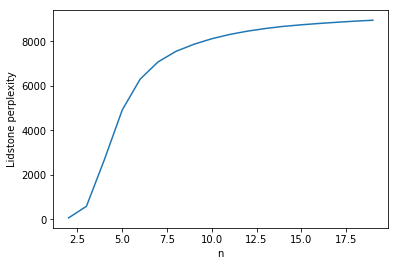

In [40]:
gamma = 0.95
xvals = list()
yvals = list()
for n in range(2,20):
    ptb_model = train_word_lm(train_data, n)
    xvals.append(n)
    yvals.append(perplexity_lidstone(ptb_model, valid_data, gamma, n))

plt.plot(xvals,yvals)
plt.xlabel('n')
plt.ylabel('Lidstone perplexity')  

Perplexity against different values of *n. The perplexity gets worse when n increases. This result is expected, since the model becomes more sparss when n* is greater.

In [42]:
# learn 2-gram 
ptb_model = train_word_lm(train_data, 2)

# compute perplexity against ptb.valid with gamma = 0.95
print(perplexity_lidstone(ptb_model, valid_data, 0.95))

# compute perplexity of worst case model
valid_as_list = valid_data.split()
train_as_list = train_data.split()
e = 0.0
n = 0
for token in valid_as_list:
    if token in train_as_list:
        e += -math.log(1/10000,2)
        n += 1
e = e / float(n)
print(math.pow(2, e))

68.71189163272935
10000.0000001082


The perplexity of the model trained with ptb.train against ptb.valid is 68.71. Natuarlly, it is much worse than the perplexity of the model against its own training data. The perplexity of the worst case is 10,000.
<br>
[This paper](https://openreview.net/forum?id=ByQZjx-0-&noteId=rJWmCYxyM)  from 2018, shows a summary of recent results over the Penn Treebank dataset. Worst reported perplexity is from 2014 and is equal to 78.4 [(Zaremba et al., 2014)](https://arxiv.org/abs/1409.2329), worse then our reported result of 68.7. Best reported result is from 2017, and is equal to 51.1 [(Krause et al., 2017)](https://arxiv.org/abs/1709.07432). 

### 1.3.2: Generating Text from a Language Model

In [8]:
import random

# generates random sentence from the model
def generate(model, seed, nwords=10):
    random.seed(seed)  # initialize random generator with seed
    keys = model.conditions()
    first_key = keys[0]
    first_key = first_key.split()
    n = len(first_key)
    num_probs = len(model)
    # choose first n words randomly
    random_text = list()
    j = random.randint(0, num_probs-1)
    random_text.extend(keys[j].split())
    # choose rest of the text with the model
    for i in range(nwords-n):
        context = random_text[len(random_text)-n:]
        context = ' '.join(context)
        probDist = model[context]
        random_text.append(probDist.max())
    return ' '.join(random_text)

The above function recives an n-gram model (the output of train_word_lm), and generates a sentence, i.e. a text of 10 words. The next codes shows generation of sentences with different seeds, of 2-gram learned with ptb.train

In [55]:
for seed in range(10):
    print('A sentece genrated with seed = ' + str(seed) + ': ' + generate(ptb_model, seed))

A sentece genrated with seed = 0: export order for a <unk> <unk> <unk> <unk> <unk> <unk>
A sentece genrated with seed = 1: parts would <unk> the <unk> of the <unk> of the
A sentece genrated with seed = 2: in how the u.s. and foreign annual interest rates and
A sentece genrated with seed = 3: began laying the <unk> of the <unk> of the <unk>
A sentece genrated with seed = 4: for pay and what 's more the minimum wage for
A sentece genrated with seed = 5: too big for the <unk> of the <unk> of the
A sentece genrated with seed = 6: agents said manufacturing shrank further in the <unk> of the
A sentece genrated with seed = 7: interest gains as market-makers searched for stock prices will continue
A sentece genrated with seed = 8: be launched next march N N to N N to
A sentece genrated with seed = 9: other money managers are <unk> <unk> <unk> <unk> <unk> <unk>


The function chooses the first n words (in this case two) as a random n-length sequence that was observed in training, and then generates the rest of the sentence based on the history, i.e. the next word is the most likely word to appear after the last n words. This method has obvious disadvantages. For exmaple, the first sentence with seed=0 "got stuck", meaning even if we kept sampling words, we will just get a long sequence of unknown. A possible way to solve this problem, would be to sample the word from the conditional distribution given the history, and not always take the word with the maximal probability.
<br>
[This article](https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/) by Russell Stewart suggests a way of doing that, by using a temprature. Temprature is an additional pramater that is used to compute transformed estimators for the conditional probabilities. High temprature (e.g. 1) will lead to a representative sampling of the conditional distribution, while low tempratue (e.g. a temprature close to 0) wil lead to sample the most probable word, like the function above.
<br>
Samir Sing published a [code](https://github.com/sameersingh/uci-statnlp/blob/master/hw2/generator.py) for sampling a word from the conditional distribution given the history, with tempratue. Each word's distribution is re-computed with the freezing function given in Stewart's article. Then a random number is generated, and the word is chosen based on the comulative distribution of the transformed probabilities. For example, if P(w1|h)=0.3 and P(w2|h)=0.7, after the transfomration with temprature = 0.5, P'(w1|h) would be 0.155 and P'(w2|h) would be 0.845. Then a random number is generated. If this number would be smaller than P'(w1|h), w1 will be sampled. Else, w2 will be sampled.

## 1.4: Character language model

 #### Summary: The Unreasonable Effectiveness of Recurrent Neural Networks

Recurrent neural networks (RNN's) have several attributes which makes them appealing for the task of text generatiom: their input and output are not of a fixed size, and they allow working with sequences by maintaining an internal state vector, which can be thought of as a memory. 
<br>
The post presents results of text-generating experiments with character-level language models. In these cases, the RNN is trained with a large corpus and models the conditional distribution of a character to come after a given sequence of characters. In the first experience, the RNN is trained with Paul Graham's corpus of papers. Altough the corpus is quite small (about 1 million characters), the outputed text is punctuated correctly (commas, apostrophes, etc.). 
In the second experiment, the RNN is trained with all of Shakespeare's work. The RNN outputs a text that is very similar to the input's structure, with names and monologues. Third, the RNN is trained with markdown pages from Wikipedia. The model seems to have learned many structures of markdown such as opening and closing paranthesis or brackets, headings, lists, etc.. The fourth experiment included a Latex source of Algebra book as a traning corpus. The Latex code that was generated by the model, almost compiled. Last, a model was trained with Linux code corpus. The generated code had very few syntactic errros. It also had good indentation. Sometimes the model decided it is time to sample a new file, so it recited the GNU license agreenment character by character, sampled a few imports and macros, and then generated the code.
<br>
Overall, the results of charcter generation with RNN are very surprising; the model can learn the syntatic structure of a language, even when the language is very hard such as Latex code. English for example, is much easier, and its structure can be learned with not so large corpus. 

#### Summary: The unreasonable effectiveness of Character-level Language Models

The article presents a maximum-likelihood unsmooth character-level language model. This model computes the conditional probabilities of a chracter given the history of n charcter, when n is the paramter of the model. 'Unsmooth' means that if a character c was never observed during training after history h, then P(c|h) would be 0.
<br>
The author claims that altough this model is very simple, especially compared to RNN, it can show equal performence. Several results for increasing values of n are presented, all models are trained with Shakespeare's works. With n=2, i.e. two characters history, the text generated by the model is not so impressive. However, with n=4 (one and a half word history) and n=10 (two words history) the results are impressive, and does not fall short to the RNN's Shakespeare's generation.
<br>
Later, the authors presents the model capabilities of code generation. In this case the model is not very succefull. Even with n=20, the generated code is not indented properly, paranthesis are not always closed after they were open, etc.. RNN outpreform the maximum-likelihood model in code genration, since this task requires a longer memory.

We now read and present some usefull statistics over a large corpus of recipes.

In [76]:
# read recipes and store them in one string
import os
cwd = os.getcwd()
recipes = ''
for file in os.listdir(cwd):
    if file.endswith(".mmf"):
        f = open(file)
        try:
            f_text = f.read()
            recipes = recipes + f_text + '\n'
        except UnicodeDecodeError:
            pass
        
# statistics

tokens = word_tokenize(recipes)  # tokenize
c = Counter(tokens)
print('Number of recipes: ' + str(c['Title'])) # number of recipes
print('Number of tokens: ' + str(len(tokens))) # number of tokens
print('Number of characters: ' + str(len(recipes))) # number of characters
# remove punctuation before creating a vocabulary
tokens_without_punct = list()
for t in tokens:
    if not re.fullmatch('[' + string.punctuation + ']+', t):
                    tokens_without_punct.append(t)
vocabulary = sorted(set(tokens_without_punct)) # create vocabulary
print('Size of vocabulary: ' + str(len(vocabulary)))

l1 = [len(t.split()) for t in recipes.split('MMMMM\n')] # count number of words in each recipe
l2 = [x for x in l1 if x] # remove zeros if exist
print('Average number of words per recipe: ' + str(statistics.mean(l2))) # average number of words per recipe
print('Standard deviation number of words per recipe: ' + str(statistics.stdev(l2))) # std of number of words per recipe

l3 = [len(t) for t in recipes.split('MMMMM\n')] # count number of characters in each recipe
l4 = [x for x in l3 if x] # remove zeros if exist
print('Average number of characters per recipe: ' + str(statistics.mean(l4))) # average number of characters per recipe
print('Standard deviation number of characters per recipe: ' + str(statistics.stdev(l4))) # std of number of characters per recipe

l5 = [len(t) for t in tokens_without_punct]
print('Average length of word: ' + str(statistics.mean(l5))) # average number of characters per word
print('Standard deviation length of word: ' + str(statistics.stdev(l5))) # std of number of characters per word       


Number of recipes: 9999
Number of tokens: 2161408
Number of characters: 11369830
Size of vocabulary: 45982
Average number of words per recipe: 173.57265726572658
Standard deviation number of words per recipe: 95.05501032269227
Average number of characters per recipe: 1130.9836
Standard deviation number of characters per recipe: 583.5541274577769
Average length of word: 4.513354857646023
Standard deviation length of word: 2.4267919715913866


The following code was ment to split the data into training, validation and test sets. The training set will be used for training the character-level model, and the validation set will be used to choose the best n, i.e. the one that will present the lowest perplexity. Then we will compute the perplexity of the model with the best n against the test set.

In [80]:
from operator import itemgetter
# shuffling the indices
recipes_as_list = [t + 'MMMMM' for t in re.split('MMMMM\n',recipes)] 
inds = list(range(len(recipes_as_list)))
random.shuffle(inds)
train_inds = inds[:8000] 
valid_inds = inds[8000:9000]
test_inds = inds[9000:9999]

# splitt into lists of strings
training_set = list(itemgetter(*train_inds)(recipes_as_list))
validation_set = list(itemgetter(*valid_inds)(recipes_as_list))
test_set = list(itemgetter(*test_inds)(recipes_as_list))

# convert lists to string
training_string = ''
for s in training_set:
    training_string = training_string + s + '\n'
validation_string = ''
for s in validation_set:
    validation_string = validation_string + s + '\n'
test_string = ''
for s in test_set:
    test_string = test_string + s + '\n'

# Yoav Gelberg's code with small change: gets the data as string and not a file name
def train_char_lm(data, order=4):
    lm = defaultdict(Counter)
    pad = "~" * order
    data = pad + data
    for i in range(len(data)-order):
        history, char = data[i:i+order], data[i+order]
        lm[history][char]+=1
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm


After preparing the training, validation and test sets, we will now test the model with them. We are now ready to train the model for different orders and compute the perplexities with the validation set, but since the model is not smooth, the perplexity (and the entropy) cannot be computed. There are several possibilities to deal with this problem. One is to implenemt back-off, meaning, if a character c was not observed after history h of length n, we would compute P(c|h'), when h' is h withouth the first character, and is of length n-1. We would continue to do so untill finding h' that was observed in training before c. The main disadvantage of this solution, is that we would have to train a new model with n-1, and possibly train many models for n-1,n-2,...,0. This can be computationally expensive. Another possibility is to give a constant probability instead of zero, for example 1/|V|, when V is the vocabulary. This solution might lead to worse perplexity, but it is easy to compute and implement. This is the solution we choose. 

In [87]:
sv = len(vocabulary)

# returns Pr(c|history), if history was not observed returns 1/|V|, when V is the vocabulary
def ngram_char_prob(model, c, history, sv):
    if history in model:
        d = dict(model[history])
        if c in d:
            return d[c]
    return float(1/sv)

def ngram_char_entropy(model, text, sv, n):
    text = '~' * n + text  # padding
    e = 0.0
    for i in range(len(text)-n):
        history = text[i:i + n]
        char = text[i + n]
        lp = -math.log(ngram_char_prob(model, char, history, sv),2)
        e += lp
    return e / float(len(text) - n)

def ngram_char_perplexity(model, text, sv, n=2):
    return math.pow(2, ngram_char_entropy(model,text, sv, n))

min_perplex = math.inf
best_n = 0
for n in range(1,21):
    model = train_char_lm(training_string, n)
    curr_perplex = ngram_char_perplexity(model, validation_string, sv, n)
    print('perplexity for n=' + str(n) + ': ' + str(curr_perplex))
    if curr_perplex<min_perplex:
        min_perplex = curr_perplex
        best_n = n
print(best_n)
print(min_perplex)

perplexity for n=1: 11.851328790787448
perplexity for n=2: 6.027496800732524
perplexity for n=3: 3.7777365723861096
perplexity for n=4: 3.1958285614879722
perplexity for n=5: 3.3300457688218303
perplexity for n=6: 3.9329454464593625
perplexity for n=7: 5.121621689891524
perplexity for n=8: 7.188303030937075
perplexity for n=9: 10.614886366747537
perplexity for n=10: 16.144267252644912
perplexity for n=11: 24.841451963086826
perplexity for n=12: 37.9452079804557
perplexity for n=13: 57.46448671364883
perplexity for n=14: 85.98737959324924
perplexity for n=15: 126.51710310489217
perplexity for n=16: 181.60346141290157
perplexity for n=17: 254.1467690067802
perplexity for n=18: 345.898649333088
perplexity for n=19: 458.60057449100213
perplexity for n=20: 592.409973961893
4
3.1958285614879722


Best perplexity is recieved for n=4. Small n's are worse since the generalization is not good enough. Larger n's are worse (especially those at the high end) due to increasing sparsity. We now report the perplexity of the test set with a 4-gram model.


In [91]:
n = 4
model = train_char_lm(training_string, n)
print(ngram_char_perplexity(model, test_string, sv, n))

3.228758637186779


Next, we generate text with the model. We use Yoav Goldberg's code

In [94]:
# generating from the model
from random import random

def generate_letter(lm, history, order):
        history = history[-order:]
        dist = lm[history]
        x = random()
        for c,v in dist:
            x = x - v
            if x <= 0: return c

def generate_text(lm, order, nletters=1000):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

model = train_char_lm(recipes, 4)
print(generate_text(model, 4, 7000))


~~
  other through Sweetened
  chips until fork.  Sprinks)
  
  Source:  then....................  Cover togethern wire saltern Cool
       1 tb Olive mint, HWWK11B, Fruit
 
      15 minute of
        1/4 cups warm.
  
     1/4 c  Extract
 
      Yield: 8 Servings
 
  THE RIBS
      Title: IMPOSSIBLE PIE
 Categories: Vegetables
       2 ts Parmesan contie or popped onion, crusts white" is slowly, 4 c  Breadmake of iron GEnie
  for 45 minutes, add covered and keep
      1 tb Whole, and
     Medium sauce.
  
  Cut in 10-15 min.
 
MMMM------
               4 lb Chocolate beef
  through an equal read and rosemary Fresh ginger, to
  30 callion finger.
 
MMMMM
 
MMMM
 
MMMM
 
MMMMMM------INGREDIBLE INTO A 1/4 c  Fine in be VERY
 Categories: Subject:
  :     6 c  Note:  Cut event. Add crushed
 
  Each tiness until trength.)
       *         1 c.  Add the lids with grant cous and top recipe via Meal-Masted butter
    1/2-inches or ported cheese. Poultry
  Do not ends an
    Cloves
 
          

Although the 4-gram model had the best perplexity, its performance in text generation is not that good. Only one recipe from the five we wanted to generate starts as it should: "MMMMM-----Recipe...". What seems to be the first recipe has a correct structure of title and category. Whenever "Title" appears at the rest of the recipes, there is a name following it with all capital letters. There is no one proper ingredient list, either the ingredient are mixed with orders, or they don't make sense, for example: "1 teaspoon of the coarse cool,..., 1 minutes F. Grill amon".
<br>
We conclude that altough the 4-gram model presented the best perplexity, the task of text generation would require a model with a larger n, like we saw in Yoav Goldberg's article. This makes sense, since the recipe has a structure that requires more memory than one word back, to learn.

In [95]:
model = train_char_lm(recipes, 20)
print(generate_text(model, 20, 7000))

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: HOW TO COOK A DUCK
 Categories: Poultry
      Yield: 4 Servings
 
 
    1 3/4 c  flour
      3/4 c  skim milk
      1/4 c  olive oil
  :          ****** Tomato & Balsamic
  :          Vinaigrette ******
      1/2    bottle Rioja red wine
        1 TB Dijon mustard
      3 tb Dried rosemary
    1/2 ts Salt
      1 ts Cinnamon; Ground
    1/8 ts Pepper
 
   Spray a large skillet with Pam. In the skillet cook ham, celery, and
  onion till vegetables are tender. Serve large bowls of this thick
  soup with crusty French bread to
  sop up the tasty juices."
  
  From 1993 "Shepherd's Garden Seeds Catalog," pg. 59. Electronic
  format by Cathy Harned.
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: BANANA TEA LOAF
 Categories: Breads, Cranberries
      Yield: 8 Servings
 
      3 lb Roasting Chicken
      3 ts Garlic, chopped
      3 tb Butter
      2 oz Baking chocolate; melted
           - (1 stick)
 
  Cook s

With n=20, the performance of the model is much improved!

#                                    Part 2

## 2.1 Synthetic Dataset Generation

In this section we create the following vectors: 
1. A vector x with N evenly separated points in the [0, 1] interval. 
2. A vector t of "noisy" points generated using the f(x) function for the points above and the normal distribution. 

We end by visualising the noisy points we've generated.

In [3]:
# imports needed throughout
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

In [4]:
# N evenly separated points in the [0, 1] interval and noisy points with the f function.
def generateDataset(N, f, sigma):
    mu = 0
    x = np.linspace(0.0, 1.0, num=N)
    noise = np.random.normal(mu, sigma, N)
    t = f(x) + noise
    return x,t

#The original function we will use throughout
def f(x): return math.sin(2 * math.pi * x)

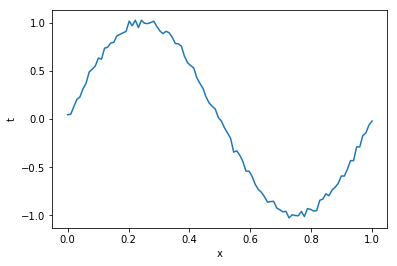

In [5]:
N = 100
vf = np.vectorize(f) # Create a vectorized version of f
sigma = 0.03
x,t = generateDataset(N, vf, sigma)
plt.plot(x, t)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

Visualizing the generated noisy vector 't'

                       
                       
##                      2.2 Polynomial Curve Fitting

Here we will attempt to learn the function y given a synthetic dataset (x, t),
using the Least-Squares method. 

In [11]:
# 2.2 

#create the phi matrix used in the least squares closed form. 
def create_phi(x,M):
    phi = x**0
    for m in range(1,M+1):
        phi = np.vstack([phi, x**m])
    return np.transpose(phi)

#creates the estimated function (y_hat) using the learned parameters W, 
#and the points on the interval x.
def y_hat(M, x, W):
    sum = np.zeros_like(x)
    for i in range(M+1):
        sum += W[i]*(x**i)
    return sum

In [12]:
# The leaset squares formula for finding the coefficients vector w, given the phi matrix. 
def LS(phi, t):
    prod = np.dot(phi.T, phi)
    i = np.linalg.inv(prod)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w
    
# finds the phi matrix and returns the coefficients vector w.
def OptimizeLS(x, t, M):
    phi = create_phi(x,M)
    WLS = LS(phi, t)
    return WLS

# plot the graphs for the least squares section
def plot_least_squares(x,y_curr,title,y_type):
    plt.plot(x, y_curr)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel(y_type)
    plt.show()

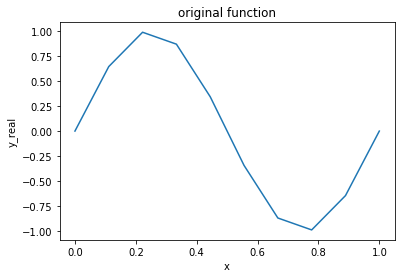

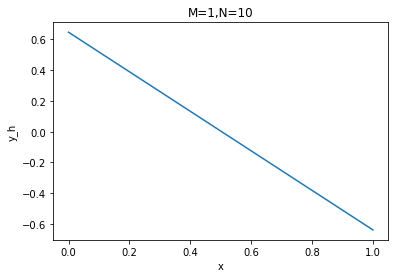

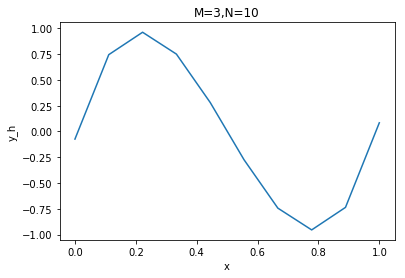

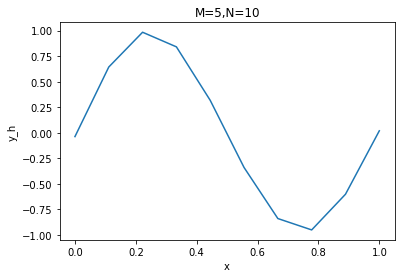

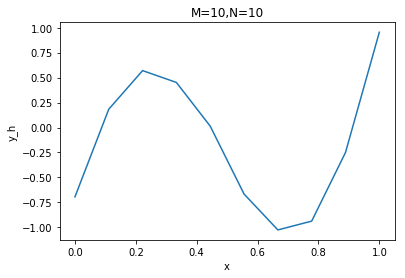

In [13]:
#for the different values of M, plotting the evaluated function using LS.
N=10
x,t = generateDataset(N, vf, sigma)
y_real = vf(x) # the real function
plot_least_squares(x,y_real,"original function","y_real")
for M in [1,3,5,10]:
    wls = OptimizeLS(x, t, M)
    y_h = y_hat(M, x, wls)
    plot_least_squares(x,y_h,"M={},N={}".format(M,N),"y_h")

Visualizing the approximations for f(x) when using differnet M values.  

## 2.3 Polynomial Curve Fitting with Regularization

In order to avoid over-fitting, in this section we will use the regularization method to reduce the complexity of the learned model w.

In [15]:
# returns 3 pairs of vectors of size N each, 
#(xtest, ttest),(xvalidate, tvalidate) and (xtrain, ttrain).
def generateDataset3(N, f, sigma):
    times = 3
    mu = 0
    x_all = np.linspace(0.0, 1.0, num=N*times)
    np.random.shuffle(x_all)
    noise = np.random.normal(mu, sigma, N*times)
    data_sets = []
    for ind in range(times):
        x = x_all[ind*N:ind*N+N]
        x = sorted(x)
        t = f(x) + noise[ind*N:ind*N+N]
        data_sets.append((np.array(x),np.array(t)))
    return tuple(data_sets)

In [16]:
#Penalized least-squares method
def PLS(phi, t, lamda):
    prod = np.dot(phi.T, phi)
    penalty = lamda*np.eye(prod.shape[0])
    i = np.linalg.inv(prod + penalty)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w

# given phi return the penalized least-squares coefficient vector w
def optimizePLS(x, t, M, lamda):
    phi = create_phi(x,M)
    WLS = PLS(phi, t, lamda)
    return WLS

#calculate the normalized error of the model.
def normalized_error(x, t, w, M):
    N = x.shape[0]
    y_h = y_hat(M, x, w)
    err = 1/N * (np.sqrt(np.sum((t-y_h)**2)))
    return err 

def plot_lambdas(errs_per_lambda,M,N):
    names = ["training", "validation", "test"]
    for ind in range(len(names)):
        lists = sorted(errs_per_lambda[ind].items()) # sorted by key, return a list of tuples
        lamda, err = zip(*lists)
        plt.plot(lamda, err)
        plt.title(names[ind]+" data M={} N={}".format(M,N))
        plt.xlabel('lambda')
        plt.ylabel('normalized_error')
        plt.show()
        
def print_N(N):
    print("*********************")
    print("\tN={}".format(N))
    print("*********************")

*********************
	N=10
*********************


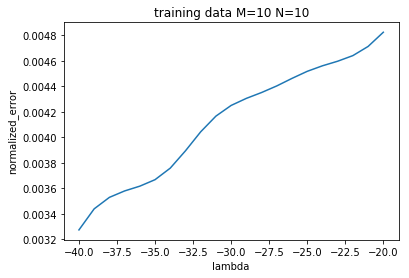

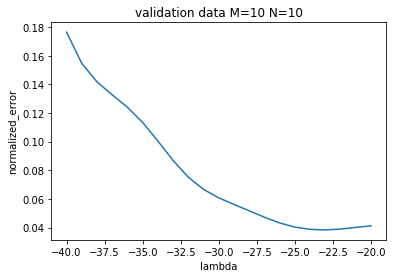

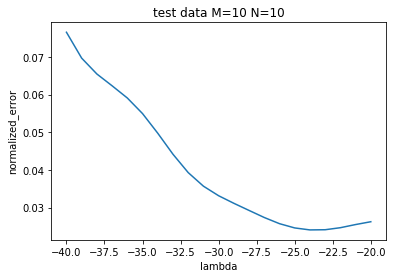

*********************
	N=100
*********************


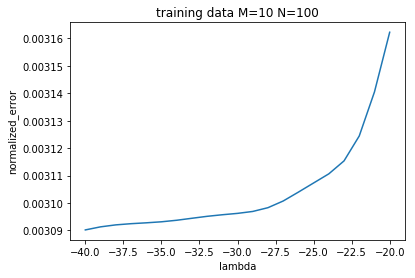

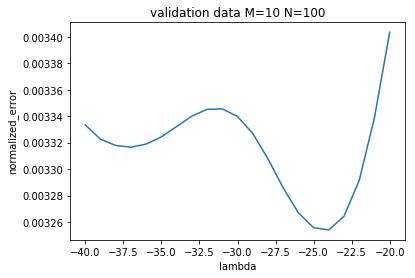

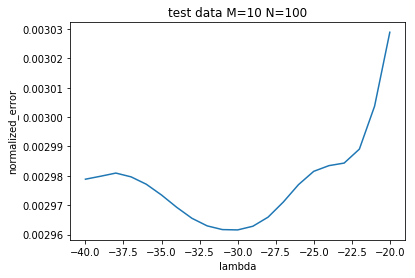

In [17]:
# show the normalized error of the model for the training, development and test sets
#for M in [1,3,5,10]:
for M in [10]:
    for N in [10, 100]:
        print_N(N)
        (xtr,ttr),(xv,tv),(xte,tte) = generateDataset3(N, vf, sigma)
        train_err_per_lambda, val_err_per_lambda, test_err_per_lambda = [{},{},{}]
        for lamda in range(40,19,-1):
            l = 1/(2**lamda)
            w = optimizePLS(xtr, ttr, M, l)
            err_tr = normalized_error(xtr, ttr, w, M)
            err_val = normalized_error(xv, tv, w, M)
            err_te = normalized_error(xte, tte, w, M)
            train_err_per_lambda[-lamda] = err_tr
            val_err_per_lambda[-lamda] = err_val
            test_err_per_lambda[-lamda] = err_te
        errs_per_lambda = [train_err_per_lambda,val_err_per_lambda,test_err_per_lambda]
        plot_lambdas(errs_per_lambda,M,N)

We see in the graphs above for M=10 (which had high overfitting before), that as we take higher regularization values, the normalized error on the training data goes up, but the error on the validation and test generally sets goes down. 
We also can conclude that this is only true up to a certain point, from which we are over regularizing and not letting the algorithm learn a good  model, which also gives worse errors on the validation and test sets.

We will now write a function which finds the optimal lamda for the validation set, and then use this lamda to plot the approximated function using the test set.

In [18]:
# selects the best value λ given a dataset
# for training (xt, tt) and a development test (xv, tv)
def optimizePLS2(xt, tt, xv, tv, M):
    err_per_lambda = {}
    for lamda in range(40, 19, -1):
        l = 1/(2**lamda)
        w = optimizePLS(xt, tt, M, l)
        err = normalized_error(xv, tv, w, M)
        err_per_lambda[-lamda] = err
    best_lambda = min(err_per_lambda, key=err_per_lambda.get)
    return best_lambda, err_per_lambda

For M=5 and N=10 the best lamda on the validation set is 2^-24.


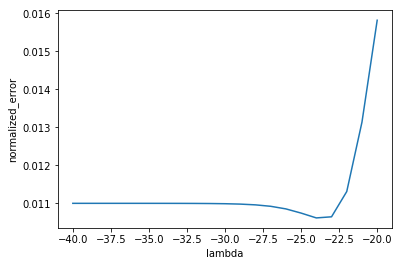

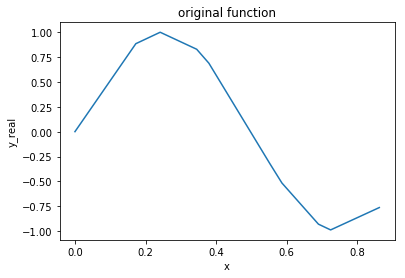

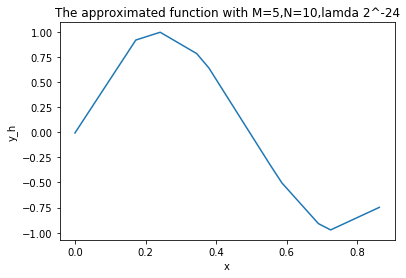

For M=5 and N=100 the best lamda on the validation set is 2^-22.


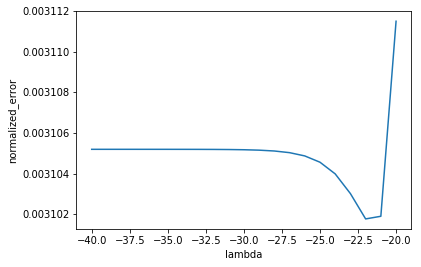

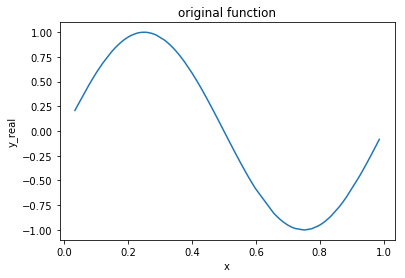

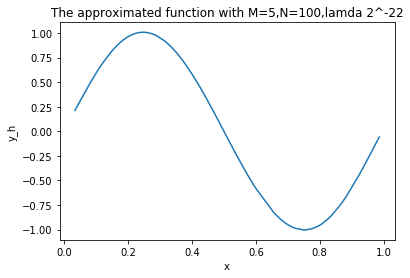

For M=10 and N=10 the best lamda on the validation set is 2^-25.


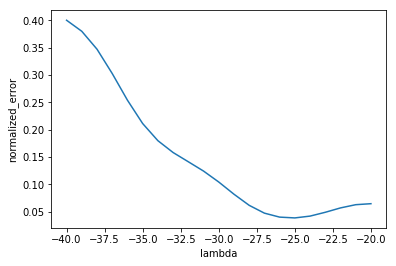

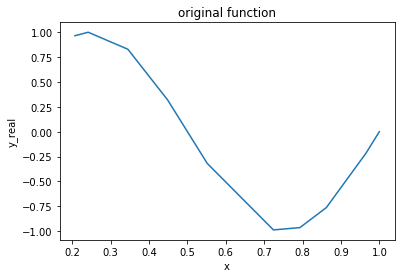

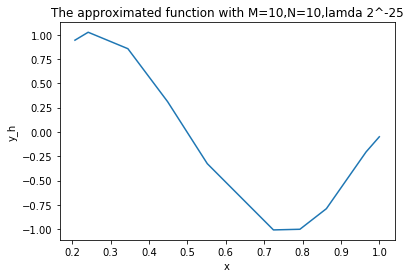

For M=10 and N=100 the best lamda on the validation set is 2^-22.


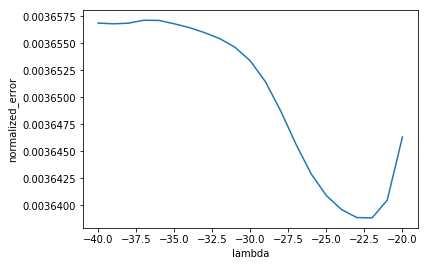

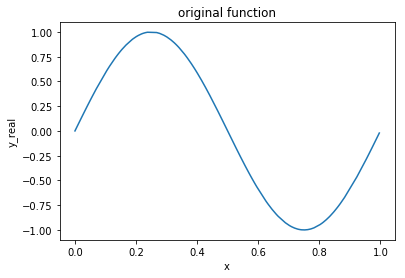

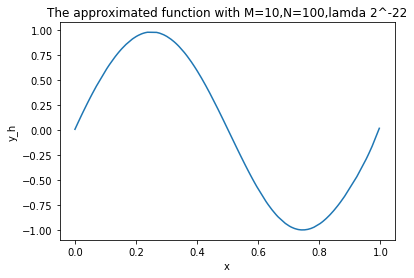

In [19]:
# show the normalized error of the model for the training, development and test sets
best_lambdas = {}
best_lambdas_per_m = []
for M in [5, 10]:
    for N in [10, 100]:
        (xtr,ttr),(xv,tv),(xte,tte) = generateDataset3(N, vf, sigma)
        best_lambda, err_per_lambda = optimizePLS2(xtr,ttr,xv,tv,M)
        best_lambdas_per_m.append(best_lambda)
        print("For M={} and N={} the best lamda on the validation set is 2^{}.".format(M, xtr.shape[0], best_lambda))
        lists = sorted(err_per_lambda.items()) # sorted by key, return a list of tuples
        lamda, err = zip(*lists)
        plt.plot(lamda, err)
        plt.xlabel('lambda')
        plt.ylabel('normalized_error')
        plt.show()
        
        
        y_real = vf(xte) # the real function
        plot_least_squares(xte,y_real,"original function","y_real")
        
        #print("The approximated function using the test data and lamda 2^{}:".format(best_lambda))
        l = 1/(2**-best_lambda)
        wls = optimizePLS(xte, tte, M, l)
        y_h = y_hat(M, xte, wls)
        plot_least_squares(xte,y_h,"The approximated function with M={},N={},lamda 2^{}".format(M,N,best_lambda),"y_h")
  

The graphs above show the normalized errors on the validation sets for M=5 and M=10, after using the penalized least-squares algorithm on the training set. We show this for datasets cunstructed of 10 and 100 points and present the real function for these points.
We take the optimal lambda for the validation set, and use it to produce the approximated function based on the penalized least squares coefficiant vector w based on the test data.
we can see that this reduces the overfitting which we had in the regular least squares method.

## 2.4 Probabilistic Regression Framework

We now tackle the regression problem with a probabilistic framework.

In [20]:
def s_inverse(alpha, sig, all_x, M):
    N = all_x.shape[0]
    sum_phi_dot = 0
    for ind in range(N):
        sum_phi_dot += np.dot(psi_bold(all_x[ind], M), np.transpose(psi_bold(all_x[ind], M)))
    s_inv = alpha*np.eye(M+1) + (1/sig**2) * sum_phi_dot
    return s_inv

def s_invinv(alpha, sig, all_x, M):
    return np.linalg.inv(s_inverse(alpha, sig, all_x, M))
    
def psi_bold(x, M):
    phi = []
    for m in range(M+1):
        phi.append(x**m)
    phi =  np.transpose(np.expand_dims(phi, axis=0))
    return phi

def get_sum_prod(all_X,t):
    sumi = t[0][0] * psi_bold(all_X[0], M)
    for ind in range(1,all_X.shape[0]):
        sumi += t[0][ind] * psi_bold(all_X[ind], M)
    return sumi

def var(x):
    return lambda sig, alpha, all_X, M: sig**2 + np.dot(np.dot(np.transpose(psi_bold(x, M)), s_invinv(alpha, sig, all_X, M)), psi_bold(x, M))

def m(x): 
    return lambda sig, alpha, t, all_X, M: (1/sig**2) * np.dot(np.dot(np.transpose(psi_bold(x, M)), s_invinv(alpha, sig, all_X, M)), get_sum_prod(all_X,t))

def bayesianEstimator(x, t, M, alpha, sigma2):
    return m, var


In [21]:
def create_plots(x,t,y_real,mu,std):
    plt.plot(x, mu, color='r')
    plt.plot(x, y_real, color='g')
    plt.fill_between(x, mu-std, mu+std, edgecolor='pink', facecolor='lightpink')
    plt.title("Without the noisy points")
    plt.show()
    #with the noisy points
    plt.plot(x, mu, color='r')
    plt.plot(x, y_real, color='g')
    plt.fill_between(x, mu-std, mu+std, edgecolor='pink', facecolor='lightpink')
    plt.scatter(x, t, color='b', marker='o', facecolors='none', )
    plt.title("Including the noisy points")
    plt.show()

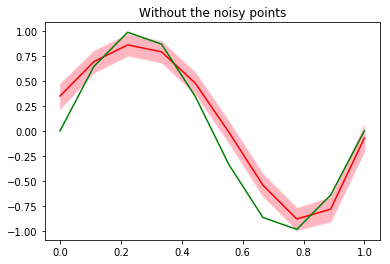

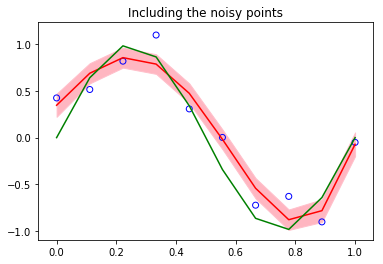

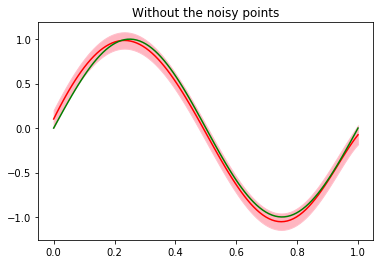

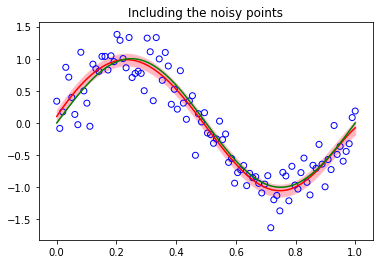

In [22]:
import statistics
alpha = 0.005
sigma2 = 1/11.1
M = 9
stds = []
for N in [10, 100]:
    x, t = generateDataset(N, vf, np.sqrt(sigma2))
    t = np.expand_dims(t, axis=0)
    m, var = bayesianEstimator(x, t, M, alpha, sigma2)
    mu = []
    std = []
    for ind in range(N):
        mu.append(m(x[ind])(sigma2, alpha, t, x, M))
        std.append(np.sqrt(var(x[ind])(sigma2, alpha, x, M)))
    mu = np.squeeze(np.array(mu))
    std = np.squeeze(np.array(std))
    y_real = vf(x)
    #creating the plots
    create_plots(x,t,y_real,mu,std)
    stds.append(statistics.stdev(np.squeeze(t)-y_real))

Given the noisy points, we can calculate the STD:

In [23]:
print("For N=10:")
print("\tthe calculated std is: {}\n".format(stds[0]))
print("For N=100:")
print("\tthe calculated std is: {}\n".format(stds[1]))

For N=10:
	the calculated std is: 0.24513020800329705

For N=100:
	the calculated std is: 0.2719566022361948



Here is our interpretion for this hight:
The STD of the noise used to generate the points around the real function f(x), was sqrt(sigma2)=0.3.
The more points we'll see, the closer we'll get to the real std.
Indeed for 10 points we are more further away than for 100 generated noisy points.
So in order to get the height to be very small in one segment of the function and large in another, we should take many samples in a certain segment, and few in another, which will lead to perhaps (though it can have the opposite effect as well) a higher margin around the approximated function.